In [ ]:
""" PIPELNE
1. Load the data.
2. Split into training/test. 80/20 - train_test_split, stratified
3.
4. Impute missing values.
5. Encode categorical variables.
6. Apply resampling to train-folds only. : SMOTE, SMOTE Tomek.
4. Training: Use Stratified K-fold splitting for training and validation sets.
5. Evaluation
6. Testing.
"""

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
!pip install pyarrow --quiet

In [94]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import math
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# MOVED TO MAIN
train_raw_df = pd.read_csv("drive/MyDrive/MLcourse/customer_segmentation_train.csv")
train_raw_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [99]:
train_raw_df['Segmentation'].unique()

array(['D', 'A', 'B', 'C'], dtype=object)

In [101]:
train_raw_df['Segmentation'].value_counts()

,count
Segmentation,
D,2268
A,1972
C,1970
B,1858


<Axes: >

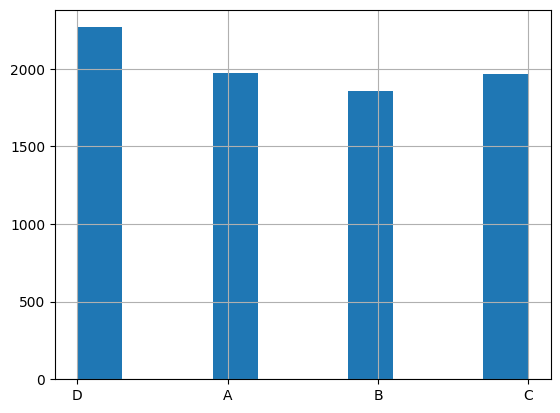

In [102]:
train_raw_df['Segmentation'].hist()

In [108]:
# MOVED TO MAIN
columns_list = train_raw_df.columns.to_list()
columns_list

['ID',
 'Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1',
 'Segmentation']

In [105]:
def split_train_test(df: pd.DataFrame, target: str):
    """
    Splits a dataset into training and test sets
    using stratified sampling based on the target variable.

    Args:
        df (pd.DataFrame): Full dataset containing features and target.
        target (str): Target column name used for stratification.

    Returns:
        X_train (pd.DataFrame): Training subset.
        X_validation (pd.DataFrame): Validation subset.
    """

    X_train, X_test= train_test_split(
        df,
        test_size=0.20,  # 80% train, 20% validation
        stratify=df[target],
        random_state=42
    )

    return X_train, X_test

In [ ]:
"""def split_dataset_cv(df: pd.DataFrame, k_folds = ): # split dataset into """


In [112]:
def detect_missing_values_cols(df: pd.DataFrame, threshold: float = 0.6):
    """
    Returns:
    - columns containing missing values
    - columns where missing percentage exceeds threshold
    """
    cols_with_na = []
    cols_to_delete = []

    for column in df.columns:
        missing_count = df[column].isna().sum()

        if missing_count > 0:
            cols_with_na.append(column)

            missing_percentage = missing_count / len(df)

            if missing_percentage > threshold:
                cols_to_delete.append(column)

    return cols_with_na, cols_to_delete

In [104]:
def impute_miss_values(df: pd.DataFrame):
  imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') # most frequent due to categorical variables
  # fit imputer on X_train, transform
  # transform only on X_test
  transformed = imputer.fit_transform(df)
  df_imputed = pd.DataFrame(
    transformed,
    columns=df.columns,
    index=df.index
  )
  return df_imputed, imputer

In [125]:
def extract_target(df: pd.DataFrame, target: str):
  """
    Separates input features and target variable from a dataset.

    Args:
    df : pd.DataFrame
        The full raw containing both feature columns and the target column.
    target : str
        Name of the target column to be extracted from the dataset.

    Return:
    input_features : A copy of the dataset without the target column (feature matrix X).
    target : A copy of the target column (label vector y).
    """
  input_features = df.drop(columns=[target]).copy()
  target = df[target].copy()
  return input_features, target

In [135]:
def drop_columns_splits(X_train: pd.DataFrame, columns_to_drop: list):
    """
    Drop specified columns from train, validation, and test splits.
    """
    X_train = X_train.drop(columns=columns_to_drop, errors="ignore")

    return X_train

In [152]:
def encode_splits_categories(X_train: pd.DataFrame):
    """
    Applies One-Hot Encoding to categorical features across train, validation,
    and test splits using a single encoder fitted on the training data only.

    Args:
    X_train : Training feature matrix used to fit the encoder

    Return:
    X_train : Transformed training set with numerical and encoded categorical features.
    encoder : Fitted OneHotEncoder instance (can be reused for inference or saved).
    categorical_features : List of categorical column names that were encoded.
    """

    numerical_features = X_train.select_dtypes(include=["number"]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

    # fit on X_train only
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoder.fit(X_train[categorical_features])

    # transform
    def _transform(inputs: pd.DataFrame) -> pd.DataFrame:
        encoded = encoder.transform(inputs[categorical_features])
        encoded_df = pd.DataFrame(
            encoded,
            columns=encoder.get_feature_names_out(categorical_features),
            index=inputs.index
        )
        return pd.concat([inputs[numerical_features], encoded_df], axis=1)

    X_train = _transform(X_train)

    return X_train, encoder, categorical_features

In [ ]:
def scale_numerical_cols(X_train: pd.DataFrame, X_validation: pd.DataFrame, scaler_numeric: bool = True):
    """
    Scales numerical columns using MinMaxScaler fitted on X_train only.
    Args:
        X_train (pd.DataFrame): Training features (used to fit scaler).
        X_validation (pd.DataFrame): Validation features to transform.
        scaler_numeric (bool): Whether to apply scaling.

    Return:
        Tuple:
            - X_train (pd.DataFrame)
            - X_validation (pd.DataFrame)
            - List of numerical columns (list)
            - Fitted MinMaxScaler object (or None if scaling disabled)
    """

    numerical_features = X_train.select_dtypes(include=["number"]).columns.tolist()

    if not scaler_numeric:
        return X_train, X_validation, numerical_features, None

    scaler = MinMaxScaler()
    scaler.fit(X_train[numerical_features])

    X_train[numerical_features] = scaler.transform(X_train[numerical_features])
    X_validation[numerical_features] = scaler.transform(X_validation[numerical_features])

    return X_train, X_validation, numerical_features, scaler

У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

# Main

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [156]:
train_raw_df = pd.read_csv("drive/MyDrive/MLcourse/customer_segmentation_train.csv")

In [157]:
columns_list = train_raw_df.columns.to_list()

In [158]:
X_train, X_test = split_train_test(train_raw_df, 'Segmentation')

In [159]:
X_train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
917,465905,Female,No,32,Yes,Artist,9.0,Low,1.0,Cat_6,A
3398,462903,Male,Yes,72,Yes,Entertainment,NaN,Average,2.0,Cat_6,B
2045,467901,Female,No,33,Yes,Entertainment,1.0,Low,4.0,Cat_6,B
8060,463613,Female,Yes,48,Yes,Artist,0.0,Average,6.0,Cat_6,A
4604,459859,Female,Yes,28,No,Doctor,9.0,Low,1.0,Cat_7,A
...,...,...,...,...,...,...,...,...,...,...,...
3822,463101,Female,No,27,No,Homemaker,8.0,Low,1.0,Cat_6,D
5864,467844,Male,No,37,Yes,Healthcare,0.0,Low,2.0,Cat_6,D
3589,460706,Female,No,27,No,Engineer,6.0,Low,6.0,Cat_4,D
1489,464339,Male,No,26,No,Artist,0.0,Low,2.0,Cat_6,D


In [160]:
X_train['Segmentation'].value_counts()

,count
Segmentation,
D,1814
A,1578
C,1576
B,1486


In [161]:
X_train, y_train = extract_target(X_train, "Segmentation")

In [162]:
cols_with_na, cols_to_delete = detect_missing_values_cols(X_train)

In [163]:
X_train = drop_columns_splits(X_train, "ID")

In [164]:
X_train

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
917,Female,No,32,Yes,Artist,9.0,Low,1.0,Cat_6
3398,Male,Yes,72,Yes,Entertainment,NaN,Average,2.0,Cat_6
2045,Female,No,33,Yes,Entertainment,1.0,Low,4.0,Cat_6
8060,Female,Yes,48,Yes,Artist,0.0,Average,6.0,Cat_6
4604,Female,Yes,28,No,Doctor,9.0,Low,1.0,Cat_7
...,...,...,...,...,...,...,...,...,...
3822,Female,No,27,No,Homemaker,8.0,Low,1.0,Cat_6
5864,Male,No,37,Yes,Healthcare,0.0,Low,2.0,Cat_6
3589,Female,No,27,No,Engineer,6.0,Low,6.0,Cat_4
1489,Male,No,26,No,Artist,0.0,Low,2.0,Cat_6


In [165]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6454 entries, 917 to 2661
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           6454 non-null   object 
 1   Ever_Married     6343 non-null   object 
 2   Age              6454 non-null   int64  
 3   Graduated        6395 non-null   object 
 4   Profession       6348 non-null   object 
 5   Work_Experience  5808 non-null   float64
 6   Spending_Score   6454 non-null   object 
 7   Family_Size      6190 non-null   float64
 8   Var_1            6394 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 504.2+ KB


In [148]:
X_train.isna().sum()

,0
Gender,0
Ever_Married,111
Age,0
Graduated,59
Profession,106
Work_Experience,646
Spending_Score,0
Family_Size,264
Var_1,60


In [149]:
X_train, imputer = impute_miss_values(X_train)

In [150]:
X_train.isna().sum()

,0
Gender,0
Ever_Married,0
Age,0
Graduated,0
Profession,0
Work_Experience,0
Spending_Score,0
Family_Size,0
Var_1,0


In [151]:
X_train

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
917,Female,No,32,Yes,Artist,9.0,Low,1.0,Cat_6
3398,Male,Yes,72,Yes,Entertainment,1.0,Average,2.0,Cat_6
2045,Female,No,33,Yes,Entertainment,1.0,Low,4.0,Cat_6
8060,Female,Yes,48,Yes,Artist,0.0,Average,6.0,Cat_6
4604,Female,Yes,28,No,Doctor,9.0,Low,1.0,Cat_7
...,...,...,...,...,...,...,...,...,...
3822,Female,No,27,No,Homemaker,8.0,Low,1.0,Cat_6
5864,Male,No,37,Yes,Healthcare,0.0,Low,2.0,Cat_6
3589,Female,No,27,No,Engineer,6.0,Low,6.0,Cat_4
1489,Male,No,26,No,Artist,0.0,Low,2.0,Cat_6


In [153]:
X_train, encoder, categorical_features = encode_splits_categories(X_train)

In [154]:
X_train

,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Age_18,Age_19,Age_20,Age_21,Age_22,Age_23,...,Family_Size_7.0,Family_Size_8.0,Family_Size_9.0,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
917,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3398,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2045,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8060,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5864,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3589,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1489,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [167]:
numerical_features = X_train.select_dtypes(include=["number"]).columns.tolist()
numerical_features

['Age', 'Work_Experience', 'Family_Size']

In [ ]:
# resample only on numerical features with SMOTE

In [ ]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?